<h2 align=center> Fine-Tune BERT for Text Classification with TensorFlow</h2>

<div align="center">
    <img width="512px" src='https://drive.google.com/uc?id=1fnJTeJs5HUpz7nix-F9E6EZdgUflqyEu' />
    <p style="text-align: center;color:gray">Figure 1: BERT Classification Model</p>
</div>

In [ ]:
!nvidia-smi     #gives basic information about your gpu.  #what is gpu?

Thu Aug  8 14:13:26 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Install TensorFlow and TensorFlow Model Garden

In [ ]:
import tensorflow as tf       #importing latest version of tensorflow and printing the version to check whether tensorflow is imported or not
print(tf.version.VERSION)

2.17.0


In [ ]:
!pip install -q tensorflow==2.3.0

ERROR: Could not find a version that satisfies the requirement tensorflow==2.3.0 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1, 2.15.1, 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0)
ERROR: No matching distribution found for tensorflow==2.3.0


In [ ]:
!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git

fatal: destination path 'models' already exists and is not an empty directory.


In [ ]:
# install requirements to use tensorflow/models repository
!pip3 install -Uqr models/official/requirements.txt
# you may have to restart the runtime afterwards

  Preparing metadata (setup.py) ... done


## Import the Quora Insincere Questions Dataset

In [ ]:
#these are the necessary libraries
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import sys
#these are the sub-modules the we cloned from the official tensorflow model garden repositories
#they are the BERT specific sub-modules
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization

ModuleNotFoundError: No module named 'keras.src.engine'

In [ ]:
#this will print the tensorflow version we are working with
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
#printing the hub version
print("Hub version: ", hub.__version__)
#informing whether GPU is available or not
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.17.0
Eager mode:  True
Hub version:  0.16.1
GPU is available


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split   #this helper function is imported from the scikit learn library to split the original dataset

#here we are using pandas to read the csv file
#these arguments are there to decompress the compressed zip file for us
df = pd.read_csv('https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip', compression='zip', low_memory= False)

#to get the number of rows and columns in the dataset
df.shape

(1306122, 3)

In [ ]:
df.tail(20)    #to extract the last 20 rows of the dataset

#qid : unique question id
#target label : binary
#Insincere : 1, Sincere : 0

,qid,question_text,target
1306102,ffff3778790af9baae76,What steps can I take to live a normal life if...,0
1306103,ffff3f0a2449ffe4b9ff,Isn't Trump right after all? Why should the US...,1
1306104,ffff41393389d4206066,Is 33 too late for a career in creative advert...,0
1306105,ffff42493fc203cd9532,What is difference between the filteration wor...,0
1306106,ffff48dd47bee89fff79,"If the universe ""popped"" into existence from n...",0
1306107,ffff5fd051a032f32a39,How does a shared service technology team meas...,0
1306108,ffff6d528040d3888b93,How is DSATM civil engineering?,0
1306109,ffff8776cd30cdc8d7f8,Do you know any problem that depends solely on...,0
1306110,ffff94d427ade3716cd1,What are some comic ideas for you Tube videos ...,0
1306111,ffffa382c58368071dc9,"If you had $10 million of Bitcoin, could you s...",0


<Axes: title={'center': 'Target Distribution'}, ylabel='Frequency'>

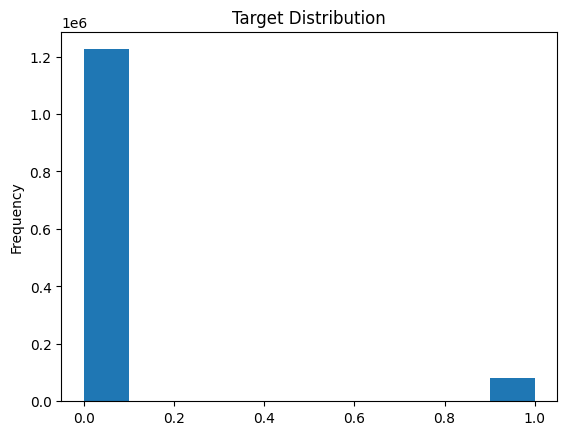

In [ ]:
#to look at the distribution of class labels, to get the idea of the imbalance in the dataset

#this will plot the histogram for specifically the 'target' column
df.target.plot(kind = 'hist', title = 'Target Distribution')


## Create tf.data.Datasets for Training and Evaluation

In [ ]:
#to split our dataset into training and validartion sets, we are using the train_test_split helper function of the scikit learn library

#creating the train and remaining datasets
train_df, remaining = train_test_split(df, random_state = 42, train_size=0.0075, stratify=df.target.values)
#this above line means, we are applying this function on original dataset, the size of this set is 0.75% of the original and we are stratifying the target column

#creating the validation set from the remaining set
valid_df, _ = train_test_split(remaining, random_state= 42, train_size= 0.00075, stratify= remaining.target.values)
#if the training size will be around 10,000 samples then the validation size will be only 1000

#to get the number of rows and columns using python
train_df.shape, valid_df.shape


((9795, 3), (972, 3))

In [ ]:
#creating two datasets train_data and valid_data from two the slices : question_text and target; with 'from_tensor_slices' method
with tf.device('/cpu:0'):
  train_data = tf.data.Dataset.from_tensor_slices((train_df['question_text'].values, train_df['target'].values))
  valid_data = tf.data.Dataset.from_tensor_slices((valid_df.question_text.values, valid_df.target.values))

#as the above returns iterables, we can get the elements with the help of for loops
for text, label in train_data.take(1):
  print(text)
  print(label)


tf.Tensor(b'Why are unhealthy relationships so desirable?', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)


## Download a Pre-trained BERT Model from TensorFlow Hub

In [ ]:
"""
Each line of the dataset is composed of the review text and its label
- Data preprocessing consists of transforming text to BERT input features:
input_word_ids, input_mask, segment_ids
- In the process, tokenizing the text is done with the provided BERT model tokenizer
"""

label_list = [0, 1] # Label categories
max_seq_length = 128 # maximum length of (token) input sequences
#length of the longest question (bert allows maximum of 512 tokens)

train_batch_size = 32

# Get BERT layer and tokenizer:
# More details here: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2

bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2", trainable= True)
#we can import the bert module as an ordinary keras layer.    what is keras layer?


#converting these two into a numpy object to get the value. Everything preceeding numpy() is the path
#the tokenizer requires the vocabulary file which was used in bert
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
#we are using the uncase version of bert, so we pass this do_lower_case to the tokenizer which tells that we are working with the uncased version
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

#instanciating the tokenizer from the bert layer (we have already imported the tokenization from bert above, here we are just using the FullTokenizer)
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)


In [ ]:
#using our instanciated tokenizer to tokenize a string, with the wordpiece tokenizer method
tokenizer.wordpiece_tokenizer.tokenize('hi, how are you doing?')

['hi', '##,', 'how', 'are', 'you', 'doing', '##?']

In [ ]:
#converting the above created tokens into token ids using the instanciated tokenizer
tokenizer.convert_tokens_to_ids(tokenizer.wordpiece_tokenizer.tokenize('hi, how are you doing?'))

[7632, 29623, 2129, 2024, 2017, 2725, 29632]

## Task 6: Tokenize and Preprocess Text for BERT

<div align="center">
    <img width="512px" src='https://drive.google.com/uc?id=1-SpKFELnEvBMBqO7h3iypo8q9uUUo96P' />
    <p style="text-align: center;color:gray">Figure 2: BERT Tokenizer</p>
</div>

In [ ]:
# This provides a function to convert raw text to input features and label

def to_feature(text, label, label_list=label_list, max_seq_length=max_seq_length, tokenizer=tokenizer):
  example = classifier_data_lib.InputExample(guid = None,
                                             text_a = text.numpy(),
                                             text_b = None,
                                             label = label.numpy())
  feature = classifier_data_lib.convert_single_example(0, example, label_list, max_seq_length, tokenizer)
  return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)



## WRAPPER FUNCTION


In [ ]:
#now we have to apply this function to our tensorflow dataset and to do that we use the dataset.map function
#but the problem with dataset.map function is that it runs in graph mode and returns graph tensors which donot have a value
def to_feature_map(text, label):
  input_ids, input_mask, segment_ids, label_id = tf.py_function(to_feature, inp = [text, label],
                                                                Tout= [tf.int32, tf.int32, tf.int32, tf.int32])
  input_ids.set_shape([max_seq_length])
  input_mask.set_shape([max_seq_length])
  segment_ids.set_shape([max_seq_length])
  label_id.set_shape([])

  x = {
      'input_word_ids' : input_ids,
      'input_mask' : input_mask,
      'input_type_ids' : segment_ids
  }

  return (x, label_id)

  #this function returns a tuple of two tensors, one containing the text and other containing the label

## Create a TensorFlow Input Pipeline with `tf.data`

In [ ]:
#creating final train and validation datasets by transforming the tensorflow datasets using the above wrapper function
with tf.device('/cpu:0'):   #specifies the device on which the TF operations will be executed. '/cpu:0' means that the operations in this block will be executed on the CPU
  # train
  train_data = (train_data.map(to_feature_map,  #we are mapping our dataset to the new values using this function
                              num_parallel_calls=tf.data.experimental.AUTOTUNE)
                          #.cache()
                          .shuffle(1000)
                          .batch(32, drop_remainder=True)
                          .prefetch(tf.data.experimental.AUTOTUNE))

  # valid
  valid_data = (valid_data.map(to_feature_map,
                            num_parallel_calls=tf.data.experimental.AUTOTUNE)
                          .batch(32, drop_remainder=True)
                          .prefetch(tf.data.experimental.AUTOTUNE))

In [ ]:
# train data spec
train_data.element_spec

({'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [ ]:
# valid data spec
valid_data.element_spec

({'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

## Add a Classification Head to the BERT Layer

<div align="center">
    <img width="512px" src='https://drive.google.com/uc?id=1fnJTeJs5HUpz7nix-F9E6EZdgUflqyEu' />
    <p style="text-align: center;color:gray">Figure 3: BERT Layer</p>
</div>

In [ ]:
# Building the classification model
def create_model():
  #three input layers are created
  input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                      name="input_word_ids")
  input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                  name="input_mask")
  input_type_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                  name="input_type_ids")
  #two outputs after Bert layer is applied to the input data
  #pooled output : representation of entire input sequence that is used for classification task
  #sequence output : representation of each token in the input sequence
  pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])

  drop = tf.keras.layers.Dropout(0.4)(pooled_output)

  #final classification output
  output = tf.keras.layers.Dense(1, activation="sigmoid", name="output")(drop)
  #final model is created specifying the input and output layers
  model = tf.keras.Model(
    inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': input_type_ids
    },
    outputs=output)
  return model

## Fine-Tune BERT for Text Classification

In [ ]:
#calling the above function to build the model before training it
model = create_model()

#compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),   #setting lower learning rate as high learning rate can cause overfitting in our model
                     loss=tf.keras.losses.BinaryCrossentropy(),
                     metrics=[tf.keras.metrics.BinaryAccuracy()])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_word_ids (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 input_mask (InputLayer)     [(None, 128)]                0         []                            
                                                                                                  
 input_type_ids (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                              

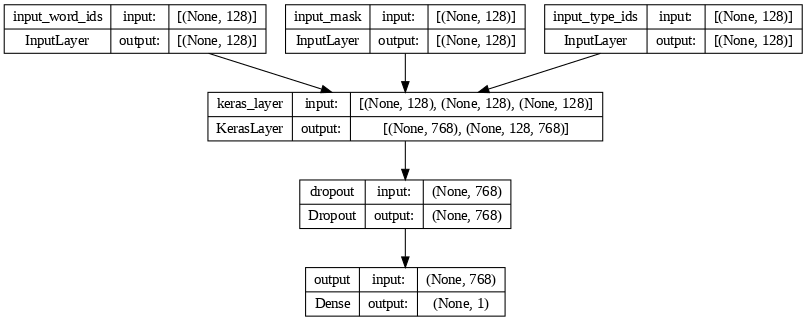

In [ ]:
#pictorial representation of the above model
tf.keras.utils.plot_model(model=model,show_shapes=True,dpi=76)

In [ ]:
# Training the TF/Keras model using the training dataset and validating its performance of validation dataset
epochs=4   #the number of times the model will iterate over the entire training dataset
history = model.fit(train_data,
                    validation_data=valid_data,
                    epochs=epochs,
                    verbose=1)

Epoch 1/4
306/306 [==============================] - 288s 811ms/step - loss: 0.1687 - binary_accuracy: 0.9370 - val_loss: 0.1167 - val_binary_accuracy: 0.9563
Epoch 2/4
306/306 [==============================] - 252s 819ms/step - loss: 0.0926 - binary_accuracy: 0.9642 - val_loss: 0.1381 - val_binary_accuracy: 0.9531
Epoch 3/4
306/306 [==============================] - 250s 813ms/step - loss: 0.0458 - binary_accuracy: 0.9830 - val_loss: 0.1534 - val_binary_accuracy: 0.9563
Epoch 4/4
306/306 [==============================] - 250s 814ms/step - loss: 0.0188 - binary_accuracy: 0.9934 - val_loss: 0.2105 - val_binary_accuracy: 0.9625


## Evaluate the BERT Text Classification Model

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

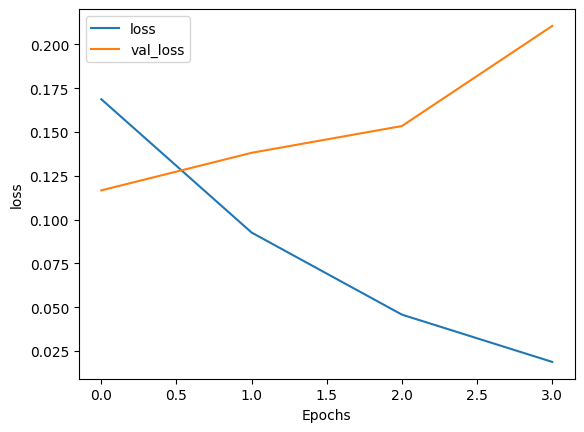

In [ ]:
plot_graphs(history,'loss')

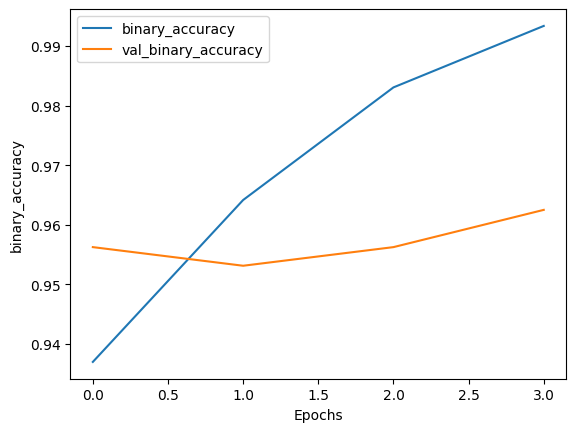

In [ ]:
plot_graphs(history,'binary_accuracy')

In [ ]:
#example to test our model
sample_example = ["Are Americans Idiots?",\
                  "Why is Messi the GOAT?",\
                  "Why are Indians Brown?",\
                  "Is trump retarded?",\
                  "What is the importance of milk?"
                  ]

#creating the tensorflow dataset from the above examples
test_data = tf.data.Dataset.from_tensor_slices((sample_example, [0]*len(sample_example)))
#mapping the text into format required by BERT
test_data = (test_data.map(to_feature_map).batch(1))
preds = model.predict(test_data)

5/5 [==============================] - 0s 22ms/step


In [ ]:
preds


array([[9.9894017e-01],
       [3.4370205e-01],
       [9.7108948e-01],
       [9.9699080e-01],
       [5.1822724e-05]], dtype=float32)

In [ ]:
['Toxic' if pred >=0.5 else 'Sincere' for pred in preds]

['Toxic', 'Sincere', 'Toxic', 'Toxic', 'Sincere']